**Bert model op basis van Robbert. Context handling moet nog aangepast worden. Oversampling a.d.h.v de mediaan. dynamisch treshhold zoeken voor unknown.**

In [1]:
#context en question bij elkaar import pandas as pd
import re
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from imblearn.over_sampling import RandomOverSampler
import torch.nn.functional as F
import os 
import pandas as pd

In [2]:
import torch

# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
# ✅ 1. Load & Preprocess Data
script_dir = os.getcwd() # Ga één map omhoog om 'baseline' te verwijderen en ga naar 'Data'
project_root = os.path.dirname(script_dir)  # Dit verwijdert 'baseline' van het script_dir
data_folder = os.path.join(project_root, "Data")

# 1. Dataset inladen
file_path = os.path.join(data_folder, "Grote_data.xlsx")
df = pd.read_excel(file_path)

In [4]:
# Drop unnecessary columns
if "TXT_file_name" in df.columns:
    df = df.drop(columns=["TXT_file_name"])

# Handle missing values
df = df.dropna(subset=["question"])
df["context"].fillna("", inplace=True)

# ✅ 2. Define Dutch Stopwords & Cleaning Function
dutch_stopwords = {"de", "het", "een", "en", "van", "ik", "te", "dat", "die", "in", "je", "is",
                   "niet", "op", "aan", "met", "als", "voor", "zijn", "was", "heeft", "heb",
                   "om", "bij", "of", "geen", "dan", "toch", "maar", "wel", "meer", "doen",
                   "ook", "kan", "mijn", "zo", "dus", "zou", "kunnen"}

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\b[a-z]\)\s+', ' ', text)  # Remove enumerations
    text = re.sub(r'\b\d+\.\b', '', text)  # Remove numbered lists
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = " ".join([word for word in text.split() if word not in dutch_stopwords])
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# ✅ 3. Merge Context + Question & Apply Cleaning    !!! belangrijk in dit model wordt de context en vraag samengevoegd!!! 
df["clean_text"] = (df["context"] + " " + df["question"]).apply(clean_text)

# ✅ 4. Encode Theme Labels as Numbers
unique_themes = list(df["theme"].unique())
theme_to_id = {theme: idx for idx, theme in enumerate(unique_themes)}
id_to_theme = {idx: theme for theme, idx in theme_to_id.items()}  # ✅ Ensure mapping back from ID to theme
df["theme_id"] = df["theme"].map(theme_to_id)

C:\Users\jefva\AppData\Local\Temp\ipykernel_3332\3587450760.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["context"].fillna("", inplace=True)


In [5]:
# ✅ 5. Fix Class Imbalance with Oversampling
theme_counts = df["theme_id"].value_counts()
median_count = theme_counts.median()  # Set balancing threshold

# Oversample rare themes
sampling_strategy = {theme: int(median_count) for theme in theme_counts.index if theme_counts[theme] < median_count}
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

X_resampled, y_resampled = ros.fit_resample(df[["clean_text"]], df["theme_id"])
df_resampled = pd.DataFrame({"clean_text": X_resampled["clean_text"], "theme_id": y_resampled})

C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [6]:
# ✅ 6. Split Data into Train & Test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_resampled["clean_text"].tolist(), df_resampled["theme_id"].tolist(), test_size=0.2, random_state=42, stratify=df_resampled["theme_id"]
)

# ✅ 7. Load BERT Tokenizer & Define Dataset Class
from transformers import RobertaTokenizer, RobertaForSequenceClassification

model_name = "pdelobelle/robbert-v2-dutch-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=len(unique_themes))



class ThemeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx], padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt"
        )
        encoding["labels"] = torch.tensor(self.labels[idx])
        return {key: val.squeeze(0) for key, val in encoding.items()}

train_dataset = ThemeDataset(train_texts, train_labels, tokenizer)
test_dataset = ThemeDataset(test_texts, test_labels, tokenizer)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# ✅ 8. Load BERT Model for Classification
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(unique_themes))

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight'

In [8]:
# ✅ 9. Define Training Arguments (With Early Stopping)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,  # Increased epochs
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="epoch",  # 🔥 Log only once per epoch
    fp16=True,
    load_best_model_at_end=True
)

# ✅ 10. Define Metrics for Evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=1)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# ✅ 11. Train Model with Early Stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Stop if no improvement for 2 epochs
)

trainer.train()


C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,2.799600,2.116045,0.415236,0.604768,0.415236,0.354969
2,1.616600,1.106493,0.710253,0.723410,0.710253,0.702133
3,0.856000,0.892145,0.764326,0.823927,0.764326,0.775029
4,0.540400,0.763536,0.814657,0.842961,0.814657,0.821453
5,0.393600,0.705557,0.839653,0.862902,0.839653,0.845380
6,0.311300,0.691260,0.845094,0.872188,0.845094,0.851551
7,0.264500,0.676401,0.856147,0.875287,0.856147,0.860840
8,0.233000,0.676283,0.857167,0.879673,0.857167,0.862607


TrainOutput(global_step=23528, training_loss=0.8768759697969574, metrics={'train_runtime': 5184.2268, 'train_samples_per_second': 36.301, 'train_steps_per_second': 4.538, 'total_flos': 4.953095598686208e+16, 'train_loss': 0.8768759697969574, 'epoch': 8.0})

In [9]:
# ✅ 13. Make Predictions (With Dynamic Confidence Threshold & Short Question Handling)
predictions = trainer.predict(test_dataset)
probabilities = F.softmax(torch.tensor(predictions.predictions), dim=1)

# ✅ Dynamically Adjust the Confidence Threshold (1st Percentile)
confidence_values = torch.max(probabilities, dim=1)[0].tolist()
dynamic_threshold = np.percentile(confidence_values, 1)  # ✅ Set threshold at the 5th percentile
print(f"Dynamic Threshold: {dynamic_threshold}")  # ✅ Print the new threshold

# ✅ Predict Themes with "Unknown" for Unclear Questions
predicted_labels = []
for i in range(len(probabilities)):
    max_prob = torch.max(probabilities[i]).item()
    pred_label = torch.argmax(probabilities[i]).item()
    question_text = test_texts[i]

    # ✅ If question is too short and lacks context, assign "Unknown"
    if len(question_text.split()) < 5:
        predicted_labels.append("Unknown")
    elif max_prob < dynamic_threshold:
        predicted_labels.append("Unknown")  # ✅ Filter out low-confidence predictions
    else:
        predicted_labels.append(id_to_theme[pred_label])  # ✅ Assign label


Dynamic Threshold: 0.12438755482435226


In [10]:
# ✅ 14. Save Predictions & CLS Embeddings to Excel
output_df = pd.DataFrame({
    "Text": test_texts,
    "True_Theme": [id_to_theme[label] for label in test_labels],
    "Predicted_Theme": predicted_labels
})


output_df.to_excel("RObertThemaclassification.xlsx", index=False)
print("✅ Model Training Completed! Predictions saved.")


✅ Model Training Completed! Predictions saved.


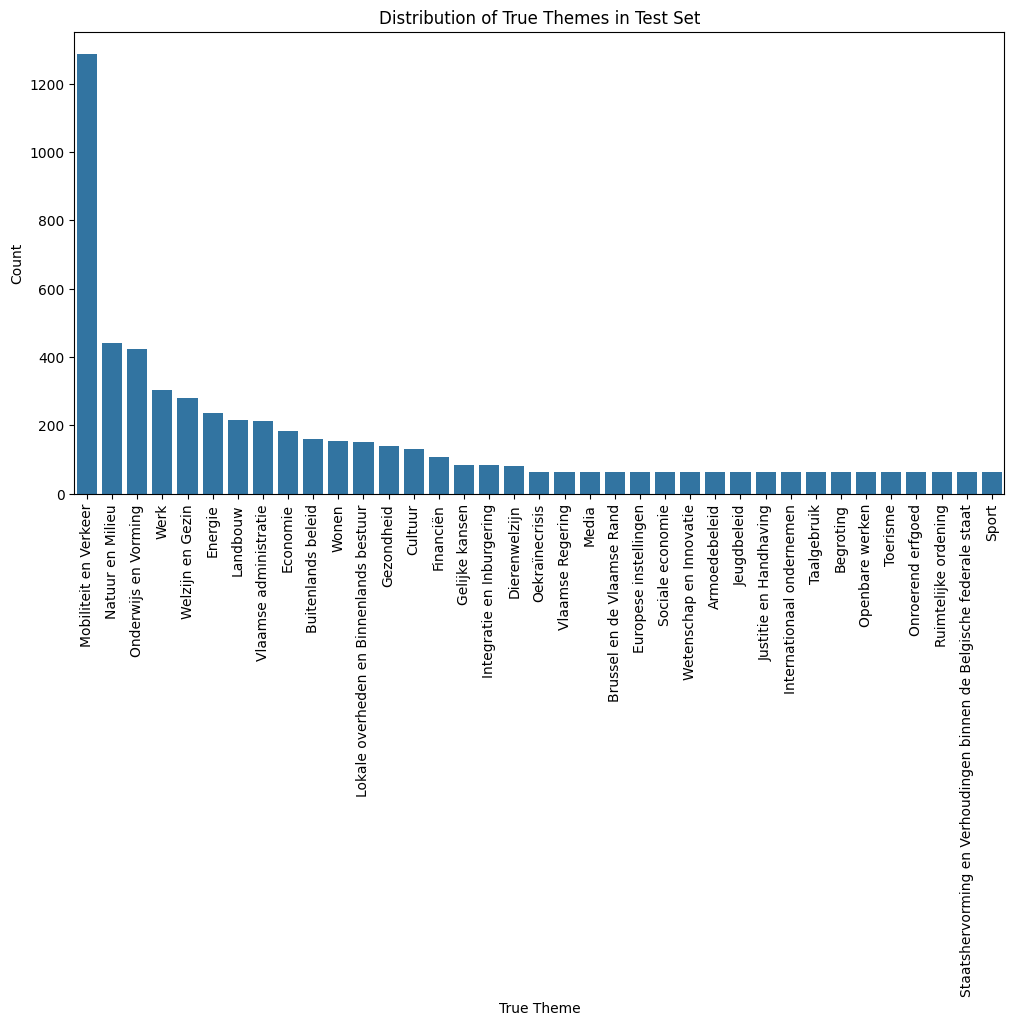

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ Convert test labels (numeric) to actual theme names
df_test = pd.DataFrame({"True_Theme": [id_to_theme[label] for label in test_labels]})

# ✅ Count occurrences of each true theme
label_counts = df_test["True_Theme"].value_counts()

# ✅ Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation=90)
plt.xlabel("True Theme")
plt.ylabel("Count")
plt.title("Distribution of True Themes in Test Set")
plt.show()


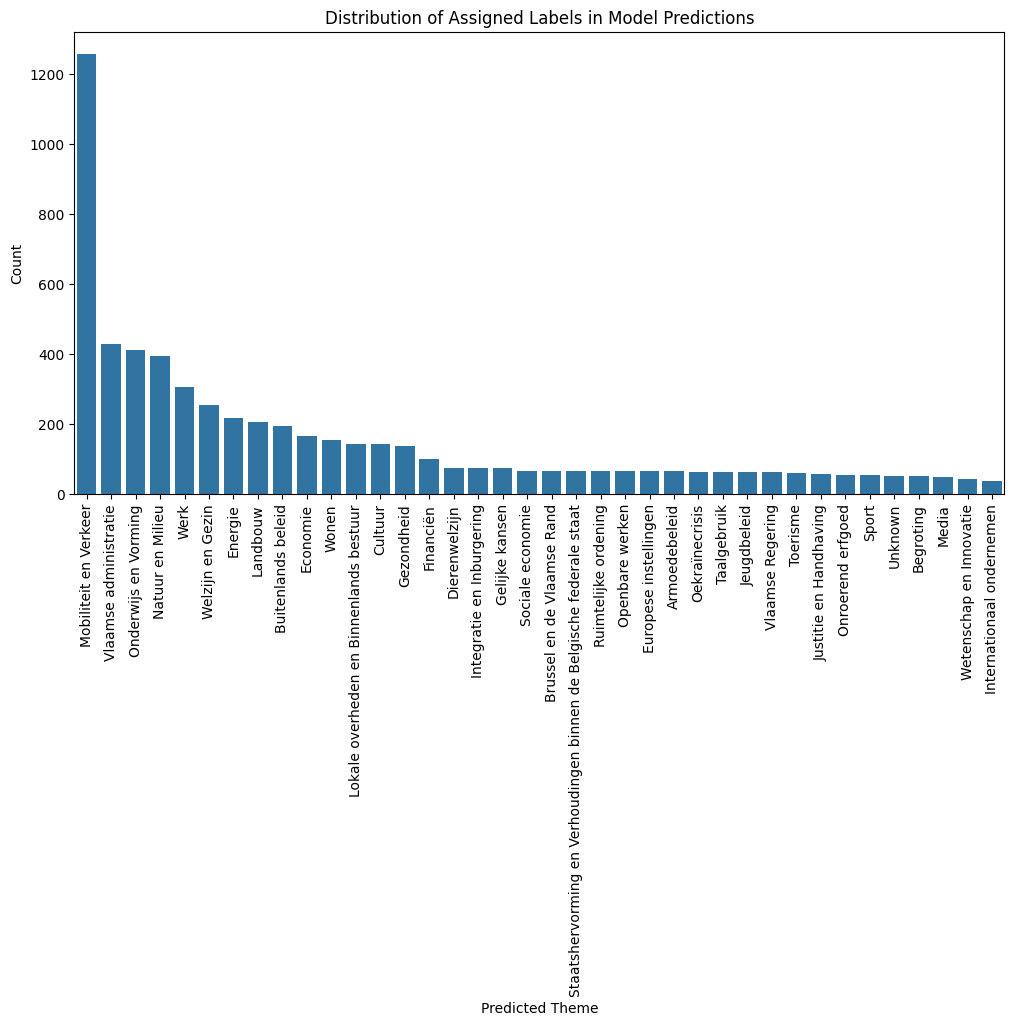

In [11]:
# ✅ 15. Visualize Distribution of Predicted Themes

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ Replace this with your actual predictions DataFrame
# Example: If your predictions are stored in a variable `predicted_labels`
# Convert it into a DataFrame for visualization
df = pd.DataFrame({"Predicted_Theme": predicted_labels})

# ✅ Count occurrences of each predicted theme
label_counts = df["Predicted_Theme"].value_counts()

# ✅ Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation=90)
plt.xlabel("Predicted Theme")
plt.ylabel("Count")
plt.title("Distribution of Assigned Labels in Model Predictions")
plt.show()


ROBERT MET CONTEXT APART gezien van de VRAAG  (nog nooit gerund)

In [ ]:
#deze met seperator context en question

import pandas as pd
import re
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from imblearn.over_sampling import RandomOverSampler
import torch.nn.functional as F

# ✅ 1. Load & Preprocess Data
file_path = r"C:\Users\jefva\Documents\Master\Thesis_s2\extracted_questions_dutch.xlsx"
df = pd.read_excel(file_path)

# Drop unnecessary columns
if "TXT_file_name" in df.columns:
    df = df.drop(columns=["TXT_file_name"])

# Handle missing values
df = df.dropna(subset=["question"])
df["context"].fillna("", inplace=True)

# ✅ 2. Define Dutch Stopwords & Cleaning Function
dutch_stopwords = {"de", "het", "een", "en", "van", "ik", "te", "dat", "die", "in", "je", "is",
                   "niet", "op", "aan", "met", "als", "voor", "zijn", "was", "heeft", "heb",
                   "om", "bij", "of", "geen", "dan", "toch", "maar", "wel", "meer", "doen",
                   "ook", "kan", "mijn", "zo", "dus", "zou", "kunnen"}

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\b[a-z]\)\s+', ' ', text)  # Remove enumerations
    text = re.sub(r'\b\d+\.\b', '', text)  # Remove numbered lists
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = " ".join([word for word in text.split() if word not in dutch_stopwords])
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# ✅ 3. Merge Context + Question & Apply Cleaning with `[SEP]` Token
df["clean_text"] = df.apply(lambda row: f"{clean_text(row['context'])} [SEP] {clean_text(row['question'])} [SEP]", axis=1)

# ✅ 4. Encode Theme Labels as Numbers
unique_themes = list(df["theme"].unique())
theme_to_id = {theme: idx for idx, theme in enumerate(unique_themes)}
id_to_theme = {idx: theme for theme, idx in theme_to_id.items()}  # ✅ Ensure mapping back from ID to theme
df["theme_id"] = df["theme"].map(theme_to_id)

# ✅ 5. Fix Class Imbalance with Oversampling
theme_counts = df["theme_id"].value_counts()
median_count = theme_counts.median()  # Set balancing threshold

# Oversample rare themes
sampling_strategy = {theme: int(median_count) for theme in theme_counts.index if theme_counts[theme] < median_count}
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

X_resampled, y_resampled = ros.fit_resample(df[["clean_text"]], df["theme_id"])
df_resampled = pd.DataFrame({"clean_text": X_resampled["clean_text"], "theme_id": y_resampled})

# ✅ 6. Split Data into Train & Test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_resampled["clean_text"].tolist(), df_resampled["theme_id"].tolist(), test_size=0.2, random_state=42, stratify=df_resampled["theme_id"]
)

# ✅ 7. Load BERT Tokenizer & Define Dataset Class
model_name = "pdelobelle/robbert-v2-dutch-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=len(unique_themes))

class ThemeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx], padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt"
        )
        encoding["labels"] = torch.tensor(self.labels[idx])
        return {key: val.squeeze(0) for key, val in encoding.items()}

train_dataset = ThemeDataset(train_texts, train_labels, tokenizer)
test_dataset = ThemeDataset(test_texts, test_labels, tokenizer)

# ✅ 8. Load BERT Model for Classification
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=len(unique_themes))

# ✅ 9. Define Training Arguments (With Early Stopping)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,  # Increased epochs
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    fp16=True,
    load_best_model_at_end=True
)

# ✅ 10. Define Metrics for Evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=1)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# ✅ 11. Train Model with Early Stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Stop if no improvement for 2 epochs
)

trainer.train()

# ✅ 12. Make Predictions (With Dynamic Confidence Threshold & Short Question Handling)
predictions = trainer.predict(test_dataset)
probabilities = F.softmax(torch.tensor(predictions.predictions), dim=1)

# ✅ Dynamically Adjust the Confidence Threshold (5th Percentile)
confidence_values = torch.max(probabilities, dim=1)[0].tolist()
dynamic_threshold = np.percentile(confidence_values, 5)  # ✅ Set threshold at the 5th percentile
print(f"Dynamic Threshold: {dynamic_threshold}")  # ✅ Print the new threshold

# ✅ Predict Themes with "Unknown" for Unclear Questions
predicted_labels = []
for i in range(len(probabilities)):
    max_prob = torch.max(probabilities[i]).item()
    pred_label = torch.argmax(probabilities[i]).item()
    question_text = test_texts[i]

    # ✅ If question is too short and lacks context, assign "Unknown"
    if len(question_text.split()) < 5:
        predicted_labels.append("Unknown")
    elif max_prob < dynamic_threshold:
        predicted_labels.append("Unknown")  # ✅ Filter out low-confidence predictions
    else:
        predicted_labels.append(id_to_theme[pred_label])  # ✅ Assign label

# ✅ 13. Save Predictions to Excel
output_df = pd.DataFrame({
    "Text": test_texts,
    "True_Theme": [id_to_theme[label] for label in test_labels],
    "Predicted_Theme": predicted_labels
})

output_df.to_excel("bert_theme_classification_robert.xlsx", index=False)
print("✅ Model Training Completed! Predictions saved.")


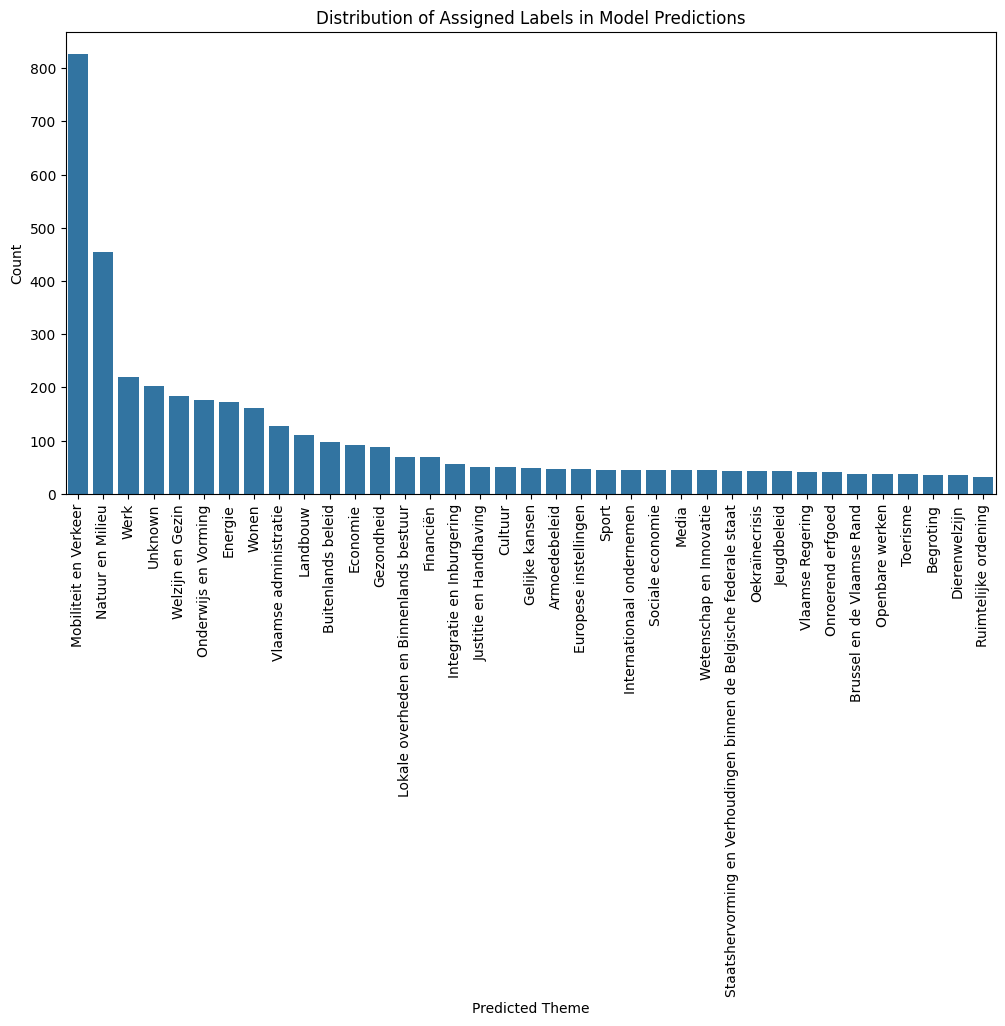

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ Replace this with your actual predictions DataFrame
# Example: If your predictions are stored in a variable `predicted_labels`
# Convert it into a DataFrame for visualization
df = pd.DataFrame({"Predicted_Theme": predicted_labels})

# ✅ Count occurrences of each predicted theme
label_counts = df["Predicted_Theme"].value_counts()

# ✅ Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation=90)
plt.xlabel("Predicted Theme")
plt.ylabel("Count")
plt.title("Distribution of Assigned Labels in Model Predictions")
plt.show()


In [5]:
# ✅ 14. Save Predictions & CLS Embeddings to Excel
output_df = pd.DataFrame({
    "Text": test_texts,
    "True_Theme": [id_to_theme[label] for label in test_labels],
    "Predicted_Theme": predicted_labels
})


output_df.to_excel("bert_theme_classification.xlsx", index=False)
print("✅ Model Training Completed! Predictions saved.")


✅ Model Training Completed! Predictions saved.
